# TP3 : Convergence de lois a posteriori et méthodes MCMC.

In [2]:
import numpy as np
from scipy import stats 
import matplotlib.pyplot as plt 

## Table des matières : 
1. [Exercice 1 : Convergence de loi a posteriori](#part1) 
2. [Exercice 2 : Algorithme de Metropolis](#part2)
3. [Exercice 3 : Metropolis vs Méthode de rejet](#part3)
4. [Exercice 4 : Algorithme de Gibbs](#part4)
5. [Exercice 5 : Algorithme de Metropolis pour l'échantillonnage d'une loi a posteriori ](#part5)
6. [Exercice 6 : Slice sampler](#part6)

## Exercice 1 : Convergence de loi a posteriori <a id="part1"></a>

On considère le modèle fondamental gausssien : 
$\begin{cases}
\boldsymbol \theta \sim \mathcal{N}(0,1) \\ 
(X_1,...,X_n) | \boldsymbol \theta \sim \mathcal{N}(\boldsymbol \theta,1)^{\otimes n}
\end{cases}$

> **Question 1:** On souhaite illustrer la consistance de la loi a posteriori $\Pi\left(\cdot | \textbf{X}\right)$ en un point $\theta_0 \in \mathbb{R}$ quelconque : $\forall \epsilon > 0 $ on a : 
> 
> $$ \mathbb{P}(|\boldsymbol \theta - \theta_0 | > \epsilon | \textbf{X}) \xrightarrow[n\to+\infty]{\mathbb P_{\theta_0}} 0.$$
>
> Tracer sur un graphique (en fonction de $n$) l'évolution de 
>
> $$\mathbb{P}(|\boldsymbol \theta - \theta_0 | > \epsilon | \textbf{X}) = 1 - F_{\textbf X}(\theta_0 + \epsilon) + F_{\textbf X}(\theta_0 - \epsilon),$$ 
>
> où $F_{\textbf X}$ est la fonction de répartition de $\Pi\left(\cdot | \textbf{X}\right)$. Prendre $\epsilon \in \{10^{-1}, 2\times10^{-1}, 5\times10^{-1}\}$.  

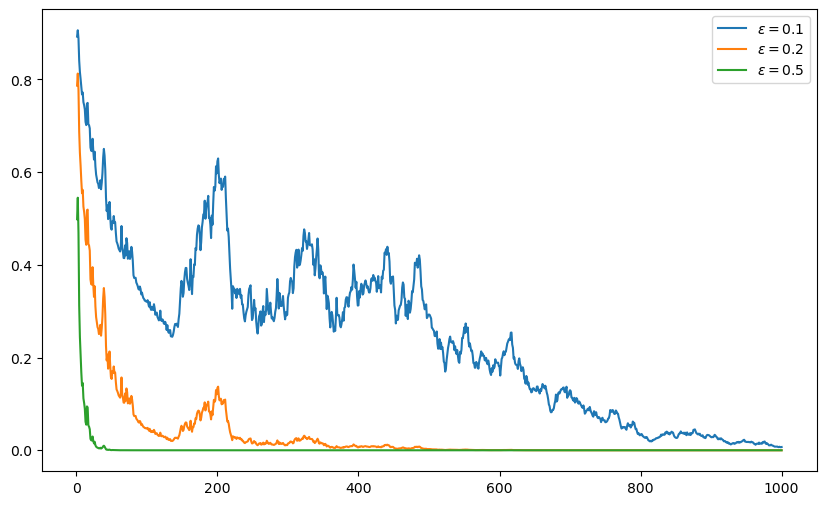

In [12]:
epsilon_values = [1e-1, 2e-1, 5e-1]
prior = stats.norm(loc = 0, scale = 1)
theta0 = prior.rvs()
ptheta = stats.norm(loc = theta0, scale = 1)

n_max = 1000
X = ptheta.rvs(size = n_max)

n_range = np.arange(1, n_max + 1)
prob = [] 

for n in n_range : 
    posterior = stats.norm(loc = X[:n].sum()/(n+1), scale = 1/np.sqrt(n+1))
    prob.append(1 - (posterior.cdf(theta0 + epsilon_values) - posterior.cdf(theta0 - epsilon_values)))
    
prob = np.asarray(prob).T

plt.figure(figsize = (10,6))

for i in range(len(epsilon_values)) : 
    plt.plot(n_range, prob[i], label = f"$\\epsilon = {epsilon_values[i]}$")
    
plt.legend()
plt.show()

>**Question 2.**
On souhaite à présent illustrer le théorème de Bernstein-von Mises :
$$
    d_{VT}\left( \Pi[\cdot | \mathbf X], \mathcal N \left(\hat \theta_n, \frac{1}{I_n(\theta_0)}\right) \right)
    \xrightarrow[n\to+\infty]{\mathbb P_{\theta_0}} 0,
$$
où $\hat \theta_n = \bar X_n$ est l'estimateur du maximum de vraisemblance.
En remarquant que $I_n(\theta_0) = n$, afficher sur les mêmes graphiques les densités des deux lois en jeu pour $n \in \{5, 10, 100, 500\}$.

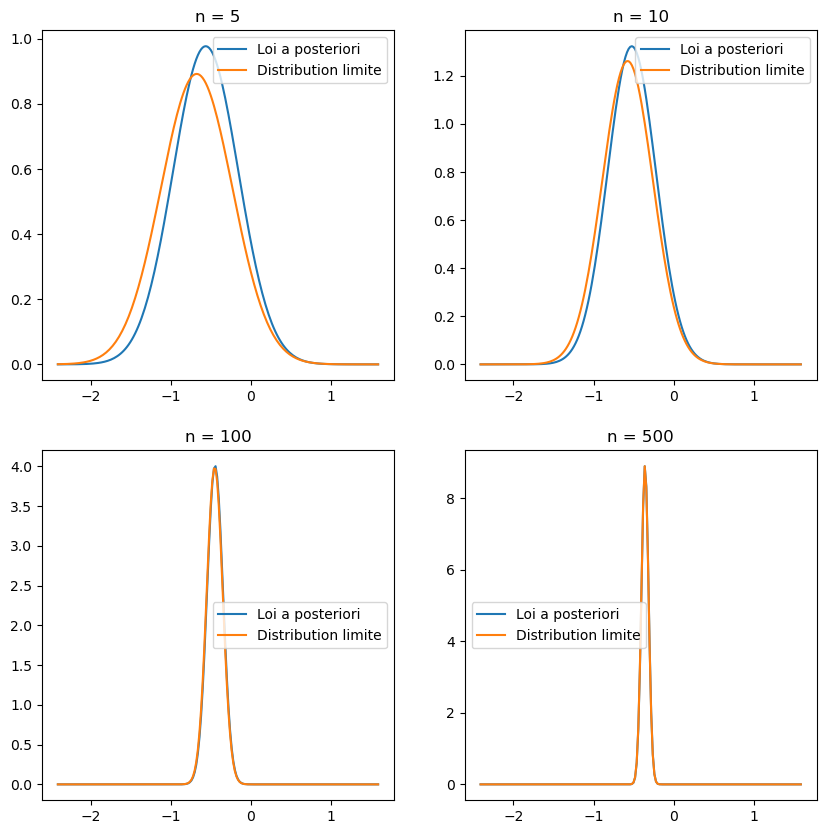

In [16]:
n_range = [5, 10, 100, 500]
x = np.linspace(X.mean() - 2, X.mean() + 2, 200)

plt.figure(figsize = (10,10))
for i, n in enumerate(n_range) : 
    posterior = stats.norm(loc = X[:n].sum()/(n+1), scale = 1/np.sqrt(n+1))
    dist_EMV = stats.norm(loc = X[:n].mean(), scale = 1/np.sqrt(n))
    plt.subplot(2, 2, i+1)
    plt.plot(x, posterior.pdf(x), label = "Loi a posteriori")
    plt.plot(x, dist_EMV.pdf(x), label = "Distribution limite")
    plt.legend()
    plt.title(f"n = {n}")
plt.show()

>**Question 3.**
>Soit maintenant le modèle bayésien :
\begin{cases}
    \boldsymbol \theta \sim \mathcal{Cauchy} \\
    (X_1, \dots, X_n) | \boldsymbol \theta \sim \mathcal N(\boldsymbol \theta, 1)^{\otimes n}.
    %\mathbf X | \boldsymbol \theta \sim \mathcal N(\boldsymbol \theta, 1)^{\otimes n}.
\end{cases}
>
>À l'aide de la fonction `sample_posterior` ci-dessous, qui échantillonne par rejet suivant la loi a posteriori $\Pi[\cdot | \mathbf X]$, illustrer le théorème de Bernstein-von Mises en représentant sur la même figure un histogramme de la loi a posteriori et la densité gaussienne cible.

In [17]:
def sample_posterior(prior, X, size = 1) : 
    k = 10 
    M = k * size # Nombre de points restants dans l'échantillon 
    unif = stats.uniform() # Distribution pour le seuil 
    EMV = X.mean() # Max de vraisemblance 
    
    sample = [] # Points acceptés 
    n_sample = 0 # Nombre de points acceptés 
    while M > 0 : 
        thetas = prior.rvs(size = M) 
        threshold = unif.rvs(size = M)
        crit = np.exp(-X.shape[0]/2 * (EMV - thetas)**2) 
        sample.append(thetas[threshold <= crit][:(size - n_sample)])
        n_sample += len(sample[-1])
        M = k * (size - n_sample) # Nombre de points restants dans l'échantillon 
    sample = np.concatenate(sample)
    
    return sample 

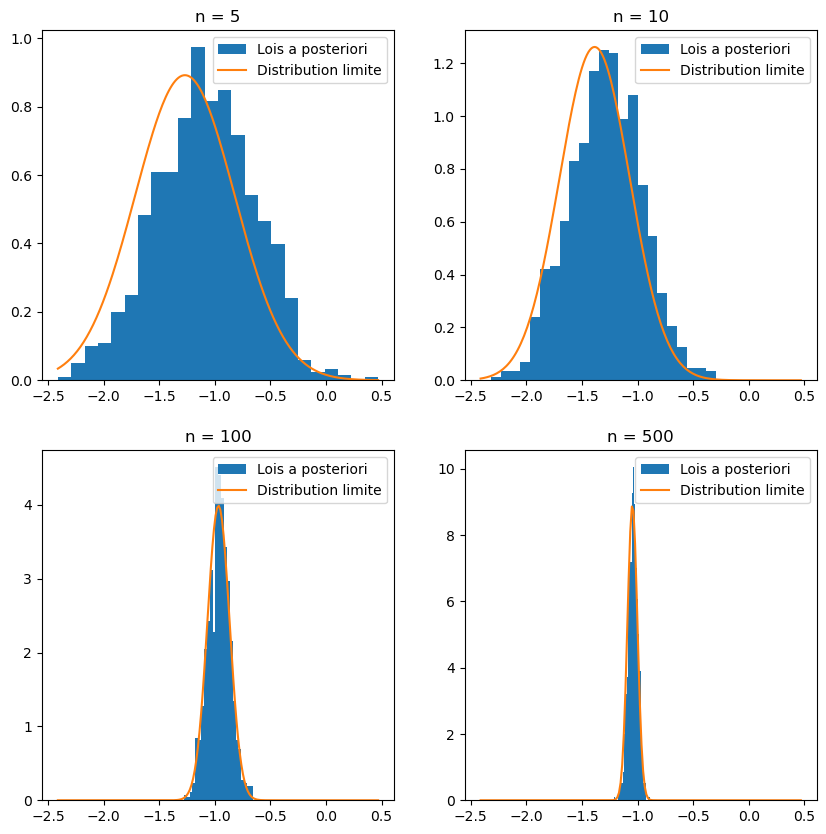

In [20]:
prior = stats.cauchy()
ptheta = stats.norm(loc = prior.rvs(), scale = 1)
n_max = 500
X = ptheta.rvs(size = n_max)

n_range = [5, 10, 100, n_max]

plt.figure(figsize = (10, 10))

for i, n in enumerate (n_range) :
    sample = sample_posterior(prior, X[:n], 1000)
    plt.subplot(2, 2, i + 1)
    dist_EMV = stats.norm(loc = X[:n].mean(), scale = 1/np.sqrt(n))
    vals, bins, _ = plt.hist(sample, bins = 'auto', density = True, label = "Lois a posteriori")
    if i == 0 : 
        x = np.linspace(bins[0], bins[-1], 200)
    plt.plot(x, dist_EMV.pdf(x), label = "Distribution limite")
    plt.legend()
    plt.title(f"n = {n}")
plt.show()

## Exercice 2 : Algorithme de Metropolis <a id="part2"></a>

On veut simuler une loi normale centrée réduite grâce à l'algorithme de Metropolis.

>**Question 1.**
On choisit comme noyau de proposition $q$ de sorte que, pour tout $x \in \mathbb R$, $q(x, \cdot)$ corresponde à la densité de la variable aléatoire $Y=x+U$ avec $U \sim \mathcal U_{[-1/2,1/2]}$.
Autrement dit, $q(x, \cdot)$ est la densité de probabilité d'aller en $y$ sachant qu'on part du point $x$. Déterminer $q(x,y)$. En déduire $q(y,x)$.

Sachant qu'on part du point $x$, la variable aléatoire $Y$ suit une loi uniforme sur $[x-1/2,x+1/2]$, donc $q(x,y)=1$ si $|y-x|\leq 1/2$, et $q(x,y)=0$ sinon. On en déduit que $q(y,x)=1$ si $|y-x|\leq 1/2$, et $q(x,y)=0$ sinon. Autrement dit, le noyau de transition $q$ est symétrique : nous sommes dans le cadre d'application de l'algorithme de Metropolis, cas particulier de Metropolis-Hastings.

>**Question 2.**
Traduire l'algorithme de Metropolis-Hastings dans ce cadre.

L'algorithme fonctionne donc comme suit : partant de $X_n=x$, on simule $W\sim{\cal U}_{[-1/2,1/2]}$ et on pose $Y=y=x+w$ ; en notant $\varphi$ la densité de la gaussienne centrée réduite, on calcule le rapport d'acceptation 
$$r(x,y)=\frac{\varphi(y)}{\varphi(x)}=e^{\frac{x^2-y^2}{2}},$$
on tire une loi uniforme $U\sim{\cal U}_{[0,1]}$, et on pose $X_{n+1}=Y=y$ si $U\leq r(x,y)$, sinon on reste sur place : $X_{n+1}=X_n=x$.

>**Question 3.**
Écrire une fonction `sample_metropolis(kernel, size=1, init=0.)` qui construit une chaîne de Markov de taille $n$ partant du point `init` selon l'algorithme décrit ci-avant.
L'argument `kernel` représente la loi de $U$, ici : `kernel=stats.uniform(loc=-0.5, scale=1)`.
La fonction devra retourner la réalisation de la chaîne et le taux d'acceptation.
>
>Appliquer cet algorithme pour construire une chaîne de longueur $n=10^4$ et partant d'un point $X_0$ tiré uniformément dans $[-3,3]$.

In [37]:
def sample_metropolis(kernel, size = 1, init = 0.0) : 
    unif = stats.uniform()
    threshold = unif.rvs(size=size)  # Seuils 
    move = kernel.rvs(size=size) 
    
    sample = [init]
    n_acc = 0
    for i in range(size):
        x = sample[-1]
        y = x + move[i]
        crit = np.exp((x**2 - y**2)/2)
        dec = threshold[i] < crit
        sample.append(y if dec else x)
        n_acc += dec
    return np.asarray(sample), n_acc/size

sample, rate = sample_metropolis(stats.uniform(loc=-0.5, scale=1), n, init=stats.uniform.rvs(loc=-3, scale=6))

>**Question 4.**
Pour la réalisation de cette chaîne, représenter un histogramme des $X_i$ auquel on superposera la densité de la loi normale centrée réduite.
Indiquer le taux d'acceptation dans le titre de la figure.
>Que pouvez-vous en dire ?

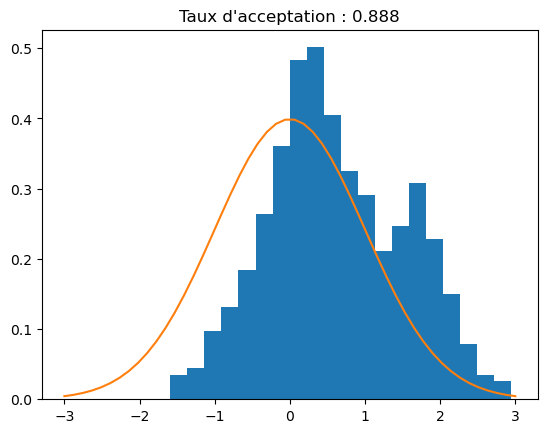

In [38]:
norm = stats.norm()

x = np.linspace(-3, 3)
plt.hist(sample, bins = 20, density = True)
plt.plot(x, norm.pdf(x))
plt.title(f"Taux d'acceptation : {rate}");

>**Question 5.**
Observer ce qu'il se passe lorsque la condition initiale est $X_0=10$.

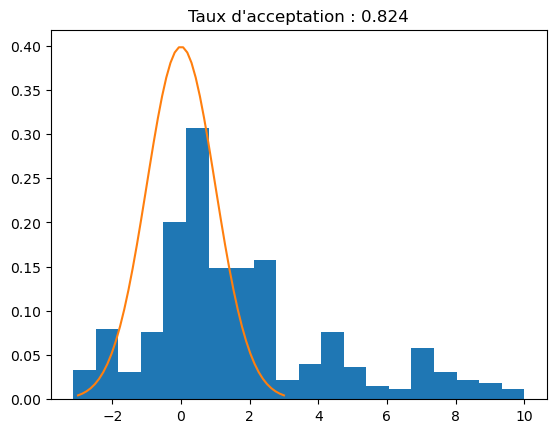

In [39]:
sample, rate = sample_metropolis(stats.uniform(loc = -0.5, scale = 1), n, init = 10.)
plt.hist(sample, bins = 20, density = True)
plt.plot(x, norm.pdf(x))
plt.title(f"Taux d'acceptation : {rate}");

Lorsque $X_0=10$, il faut plus de temps à la chaîne pour oublier la condition initiale, c'est-à-dire pour se rapprocher de l'endroit où la gaussienne met beaucoup de masse. 

>**Question 6.**
Revenons à $X_0\sim{\cal U}_{[-3,3]}$. Plutôt qu'une loi de proposition uniforme sur $[-1/2,1/2]$, considérer une loi uniforme sur $[-10,10]$. Qu'observez-vous ? Et avec une loi uniforme sur $[-0.1,0.1]$ ?

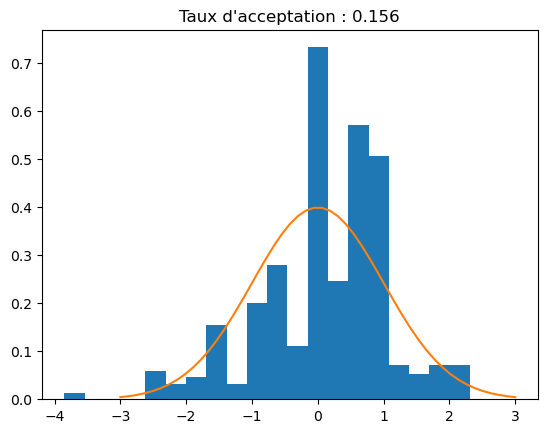

In [40]:
sample, rate = sample_metropolis(stats.uniform(loc=-10, scale=20), n)
plt.hist(sample, bins = 20, density = True)
plt.plot(x, norm.pdf(x))
plt.title(f"Taux d'acceptation : {rate}");

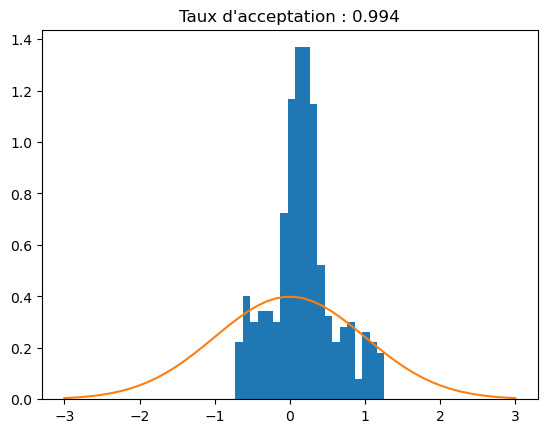

In [41]:
sample, rate = sample_metropolis(stats.uniform(loc=-0.1, scale=0.2), n)
plt.hist(sample, bins = 20, density = True)
plt.plot(x, norm.pdf(x))
plt.title(f"Taux d'acceptation : {rate}");

Lorsque la loi de proposition est une loi uniforme sur $[-10,10]$, le taux d'acceptation tombe à 15\% environ : les pas de la marche aléatoire sont trop grands. Partant d'un point vraisemblable pour la gaussienne (i.e. entre -2 et +2), la plupart des propositions tombent dans la queue de la gaussienne, donc sont refusées. Une chaîne de longueur $n=10^4$ approche mal la densité cible.

A l'opposé, avec une loi de proposition uniforme sur $[-0.1,0.1]$, le taux d'acceptation est de l'ordre de 99\%, mais la convergence est très lente : la marche aléatoire fait des pas de fourmi donc met beaucoup trop de temps à explorer la région d'intérêt, i.e. l'intervalle $[-3,3]$. Ici encore, une chaîne de longueur $n=10^4$ approche mal la densité cible.

## Exercice 3 : Metropolis vs Méthode de rejet<a id="part3"></a>

On considère la loi $G$ de densité sur $\mathbb{R}^2$ proportionnelle à 
$$f(u,v) = \left(\cos u\right)^2 \left(\sin v \right)^2 \operatorname{e}^{-\frac{1}{20}(u^2 + v^2)} $$ 

>**Question 1.**
Définir une fonction `F(U, V)` retournant $f(U, V)$ et utiliser le code ci-dessous pour afficher une représentation 3D de $f$ sur $[-5,5]\times[-5,5]$.

In [46]:
def plot_surf(U, V, Z, figsize=(10, 10)):
    fig, ax = plt.subplots(figsize = figsize, subplot_kw = dict(projection = '3d'))
    plt.rcParams['axes.grid'] = False
    surf = ax.plot_surface(U, V, Z, rstride = 1, cstride = 1, cmap = "coolwarm", linewidth = 0)
    ax.contourf(U, V, Z, zdir = 'z', offset = Z.max()+1, cmap = "coolwarm", alpha = 0.5)
    ax.set_zlim(top = Z.max()+1)
    fig.colorbar(surf)
    ax.set_xlabel('u')
    ax.set_ylabel('v')
    ax.set_zlabel('z')
    plt.rcParams['axes.grid'] = True
    
    plt.show()
    return fig, ax

In [43]:
def F(U,V) : 
    return np.cos(U)**2 * np.sin(V)**2 * np.exp(-1/20*(U**2 + V**2))

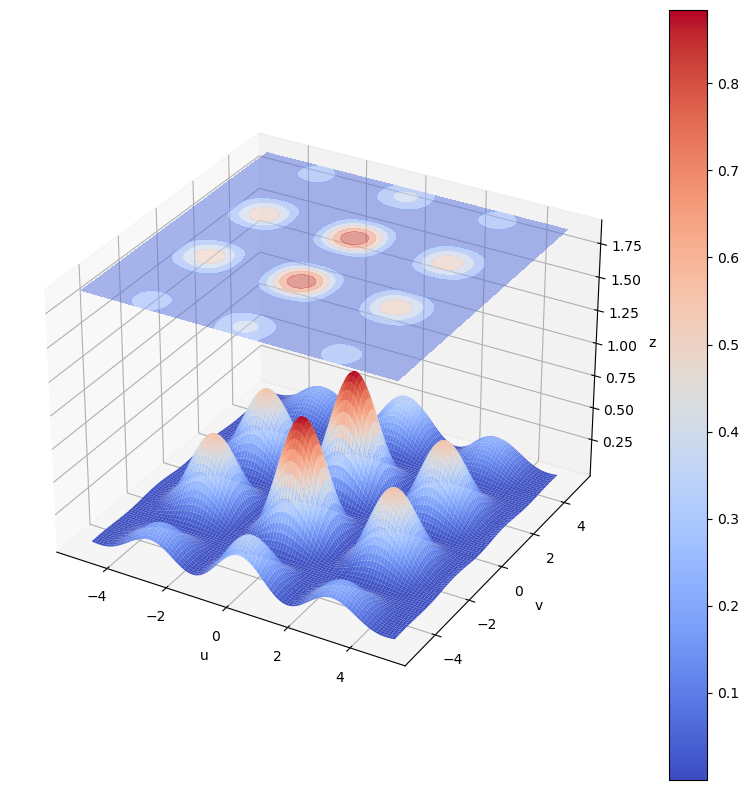

(<Figure size 1000x1000 with 2 Axes>,
 <Axes3D: xlabel='u', ylabel='v', zlabel='z'>)

In [47]:
u = np.linspace(-5, 5, 100)
v = np.linspace(-5, 5, 100)
U, V = np.meshgrid(u, v) #Toutes les paires possibles (u,v)
Z = F(U,V)

plot_surf(U,V,Z)

>**Question 2.**
On veut simuler (approximativement) selon la loi $G$ en utilisant l'algorithme de Metropolis-Hastings.
>Partant de $x=(u,v)$, on considère le noyau de proposition $q$ défini de sorte que $q(x,\cdot)$ corresponde à la densité de $Y=x+\sigma W$, où $\sigma>0$ est un paramètre de réglage et $W\sim{\cal N} \left(\binom 00,I_2 \right)$, loi gaussienne centrée réduite dans $\mathbb{R}^2$.
>Expliquer pourquoi nous sommes dans le cadre de l'algorithme de Metropolis.

Puisque $X'=x+\sigma W$, $q(x,x')$ est, vue comme une fonction de $x'$, la densité d'une gaussienne centrée en $x$ et de matrice de covariance $\sigma^2 I_2$, c'est-à-dire en notant $\|\cdot\|$ la norme euclidienne :
$$q(x,x')=\frac{1}{2\pi\sigma^2}\exp\left\{-\frac{1}{2\sigma^2}\|x'-x\|^2\right\}.$$
Cette formule étant symétrique en $x$ et $x'$, il est clair que $q(x,x')=q(x',x)$, donc on est dans le cadre de l'algorithme de Metropolis.

>**Question 3.**
Implémenter l'algorithme de Metropolis. On utilisera le noyau de transition $q$ ci-dessus avec $\sigma=1$. On pourra par exemple prendre comme initialisation $X_1=(0,0)$ et considérer une chaîne $(X_k)_{0\leq k\leq n}$ de longueur $n=10^4$. En fin de simulation, afficher le taux global d'acceptation sur l'ensemble des mutations proposées.

In [50]:
def f(x):
    u, v = x
    return F(u, v)

def sample_metropolis_2d(kernel, size = 1, init = (0.0, 0.0)) :
    unif = stats.uniform()
    threshold = unif.rvs(size = size-1)  # Array de n-1 seuils U_i
    move = kernel.rvs(size = size-1)  
    
    sample = [init]
    n_acc = 0
    
    for i in range(size-1) :
        x = sample[-1]
        y = x + move[i]
        crit = 1 if f(x) == 0.0 else f(y) / f(x)
        dec = threshold[i] < crit
        sample.append(y if dec else x)
        n_acc += dec
    
    return np.asarray(sample), n_acc/size

n = 10**4
sigma = 1

sample, rate = sample_metropolis_2d(stats.multivariate_normal(cov=sigma**2 * np.eye(2)), n)
print(f"Taux d'acceptation : {rate}")

Taux d'acceptation : 0.4441


>**Question 4.**
Sur le graphe de $f$ par lignes de niveau (`plt.contourf(U, V, Z, cmap=cm.coolwarm, alpha=0.5)`), superposer les points de la chaîne. Faire la même chose avec $\sigma$ grand, par exemple $\sigma=10$, et commenter. Idem avec $\sigma$ petit, par exemple $\sigma=0.1$. Afficher les taux d'acceptation dans les deux cas.

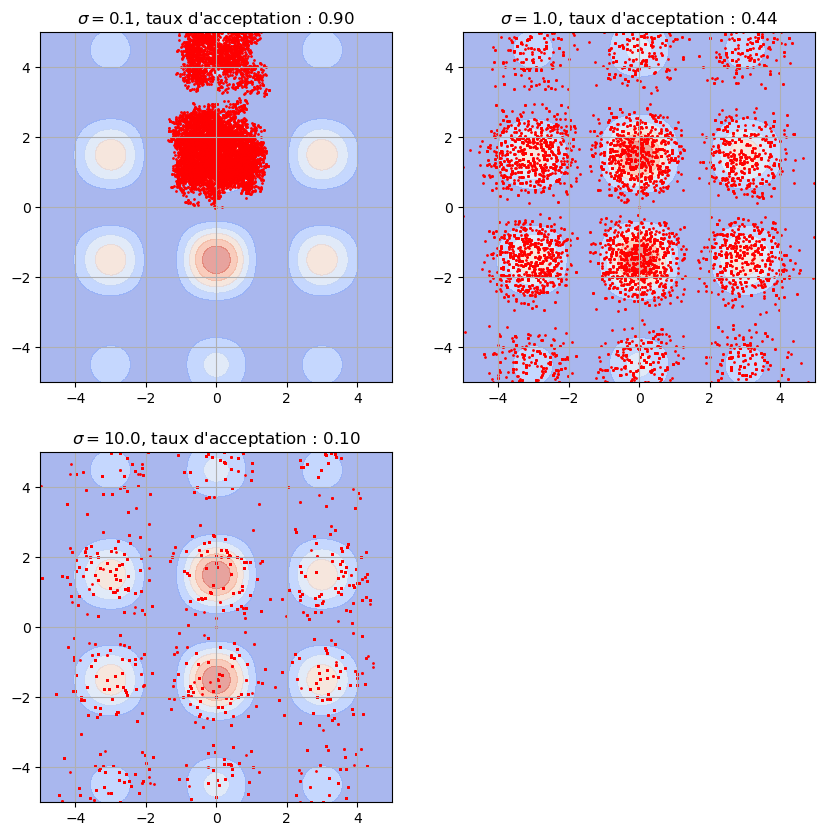

In [52]:
plt.figure(figsize=(10, 10))
for i, sigma in enumerate([0.1, 1, 10]):
    sample, rate = sample_metropolis_2d(stats.multivariate_normal(cov=sigma**2 * np.eye(2)), n)
    plt.subplot(2, 2, i+1)
    plt.contourf(U, V, Z, cmap="coolwarm", alpha=0.5)
    plt.scatter(*sample.T, c='r', s=1)
    plt.xlim([U.min(), U.max()])
    plt.ylim([V.min(), V.max()])
    plt.title(f"$\\sigma={sigma:.1f}$, taux d'acceptation : {rate:.2f}")

- Lorsque $\sigma=1$, la chaîne parvient à visiter plusieurs maxima locaux et on obtient donc une approximation satisfaisante de la loi cible $G$.
- Lorsque $\sigma$ est grand, par exemple $\sigma=10$, il y a beaucoup de propositions là où la densité de $G$ est faible, lesquelles ont donc toutes les chances d'être refusées. La loi $G$ est donc nettement moins bien échantillonnée. C'est ce qu'on constate sur le graphique.
Le taux d'acceptation est, comme on s'y attend, désastreux.
- A contrario, lorsque $\sigma$ est petit, par exemple $\sigma=0.1$, chaque proposition est très proche du point précédent donc a de grandes chances d'être acceptée. Cependant la chaîne bouge très lentement donc là encore la loi $G$ est mal échantillonnée. C'est ce qu'on constate sur le graphique.
Le taux d'acceptation est en effet très élevé.

>**Question 5.**
Proposer une méthode de rejet pour simuler suivant la loi $G$ à partir d'une loi instrumentale gaussienne. Comme en question précédente, superposer un échantillon de grande taille simulé par cette méthode aux niveaux de la fonction $f$ pour vérifier visuellement le bon fonctionnement de l'algorithme.

On commence par noter que
$$\forall(u,v)\in\mathbb{R}^2\hspace{1cm}f(u,v)\leq\exp\left(-0.05(u^2+v^2)\right)=\exp\left(-\frac{1}{20}(u^2+v^2)\right).$$
Soient donc
$$h(u,v)=\frac{1}{20\pi}\exp\left(-\frac{1}{20}(u^2+v^2)\right)$$
la densité d'une loi normale centrée et de matrice de covariance $10 I_2$
et $g = c \cdot f$ la densité de $G$ (avec $c>0$ la constante de normalisation).
On a ainsi
$$\forall(u,v)\in\mathbb{R}^2\hspace{1cm}g(u,v) = c f(u, v) \leq 20\pi\times c\times h(u,v),$$
ou encore 
$$\forall(u,v)\in\mathbb{R}^2\hspace{1cm}\frac{g(u,v)}{h(u,v)}=20\pi c(\cos u)^2(\sin v)^2\leq 20\pi c.$$
En prenant $m=20\pi c$, le rapport d'acceptation vaut donc tout simplement
$$r(u,v)=(\cos u)^2(\sin v)^2.$$

La simulation de la loi $G$ par méthode de rejet avec $h$ comme loi instrumentale s'en déduit simplement.

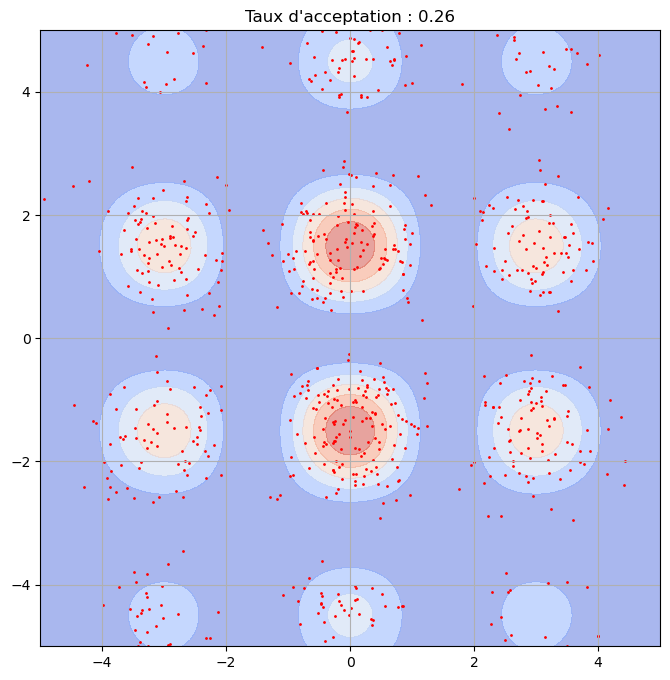

In [53]:
aux = stats.multivariate_normal(cov=10*np.eye(2))
unif = stats.uniform()

n = 10**3

sample = []
n_tot = 0
for i in range(n):
    candidate = aux.rvs()
    n_tot += 1
    while np.cos(candidate[0])**2 * np.sin(candidate[1])**2 < unif.rvs():
        candidate = aux.rvs()
        n_tot += 1
    sample.append(candidate)
sample = np.asarray(sample)
rate = n / n_tot

plt.figure(figsize=(8, 8))
plt.contourf(U, V, Z, cmap="coolwarm", alpha=0.5)
plt.scatter(*sample.T, c='r', s=1)
plt.xlim([U.min(), U.max()])
plt.ylim([V.min(), V.max()])
plt.title(f"Taux d'acceptation : {rate:.2f}");

>**Question 6.**
Des deux méthodes, laquelle vous semble préférable ?

Pour l'algorithme de rejet, on sait que le taux d'acceptation moyen est égal $\frac{1}{20\pi c}$, mais $c$ est inconnu.
Une estimation par comptage donne $\frac{1}{20\pi c} \approx \frac 14$.

Avec l'algorithme de rejet, il faut donc simuler environ $4n$ couples $(U,V)$ pour obtenir un échantillon de taille $n$. A contrario, pour $n$ simulations, l'algorithme de Metropolis fournit exactement un échantillon de taille $n$, incluant des répétitions. On peut cependant noter que l'algorithme de rejet fournit un échantillon i.i.d. selon la loi cible $G$, tandis que l'algorithme de Metropolis construit seulement une chaîne de Markov de loi stationnaire $G$ : on n'a ni indépendance, ni une simulation selon $G$ exactement (ce n'est vrai qu'asymptotiquement).  

## Exercice 4 : Algorithme de Gibbs <a id="part4"></a>

Soit $(X,Y)$ un couple de variable aléatoire de densité jointe $f(x,y)  \mapsto e^{-y}\mathbb{1}_{0 \leq x \leq y}$. 

>**Question 1.**
Déterminer la loi marginale de $X$.

$f_X(x) = \displaystyle \int_{\mathbb{R}} e^{-y} \mathbb{1}_{y \geq x} \, dy \, \mathbb{1}_{x \geq 0} = e^{-x} \mathbb{1}_{x \geq 0}.$ Autrement dit $X \sim \mathcal{E}(1)$.  

>**Question 2.**
Sachant $X=x\geq0$, déterminer la densité conditionnelle de $Y | X=x$, notée $f_{Y | X=x}$. Quelle loi reconnaissez-vous ?

$f_{Y | X=x}(y)= \dfrac{f(x,y)}{f_X(x)} = e^x \mathbb{1}_{x \geq 0}e^{-y}\mathbb{1}_{0 \leq x \leq y} = e^{-(y-x)}\mathbb{1}_{y-x \geq 0}.$ Donc $\mathcal{L}(Y | X = x) = x + \mathcal{E}(1)$. 

>**Question 3.**
En déduire une méthode pour simuler une réalisation du couple aléatoire $(X,Y)$. L'implémenter pour simuler un échantillon de couples $(X_1,Y_1),\dots,(X_n,Y_n)$ de taille $n=1000$. Représenter le nuage de points ainsi obtenu.

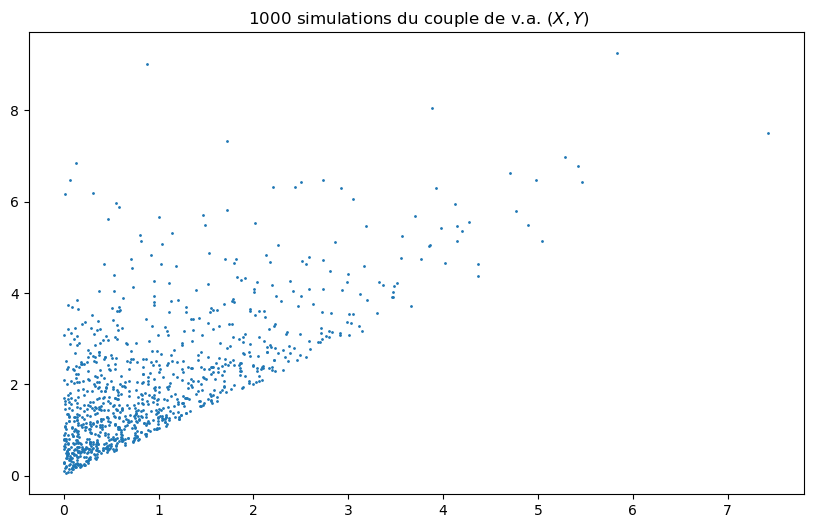

In [3]:
n = 1000 
exp = stats.expon() # Paramètre 1 par défaut. 

X = exp.rvs(size = n)
Y = np.asarray([x + exp.rvs() for x in X])

plt.figure(figsize = (10,6))
plt.grid(False)
plt.scatter(X, Y, 1)
plt.title(f" {n} simulations du couple de v.a. $(X,Y)$")
plt.show()

>**Question 4.**
Sachant $Y=y\geq 0$, déterminer la densité conditionnelle de $X | Y=y$, notée $f_{X | Y=y}$. Quelle loi reconnaissez-vous ?

$f_Y(y) = \displaystyle e^{-y}\int_0^y dx \mathbb{1}_{y \geq 0} = ye^{-y}\mathbb{1}_{y \geq 0}. $

Ainsi, $f_{X | Y=y}(x) = \dfrac{f(x,y)}{f_Y(y)} = \dfrac{1}{y}e^ye^{-y}\mathbb{1}_{0 \leq x \leq y} = \dfrac{1}{y}\mathbb{1}_{0 \leq x \leq y}$, ce qui donne que $\mathcal{L}(X | Y = y) = \mathcal{U}([0,y])$. 

>**Question 5.**
En partant par exemple du point $(x_0,y_0)=(0,1)$, proposer un échantillonneur de Gibbs pour obtenir une trajectoire $\left( (X_1, Y_1),\dots,(X_n, Y_n) \right)$ de densité cible $f$. Représenter le nuage de points ainsi obtenu.

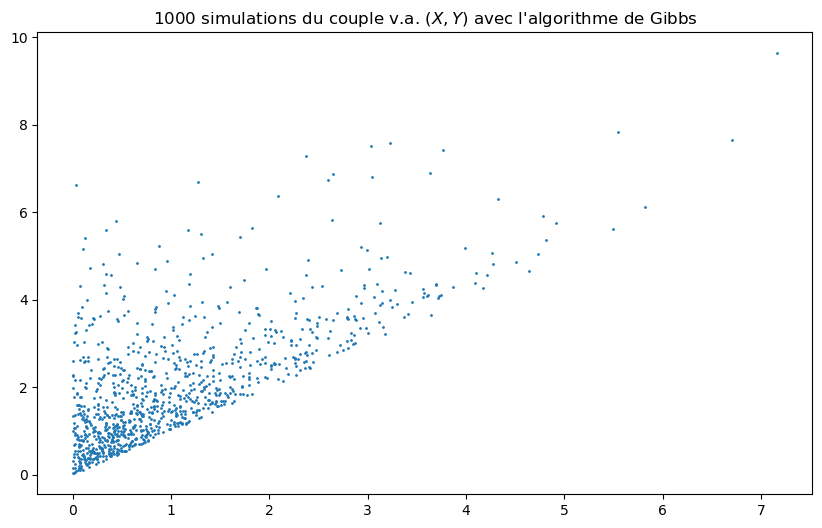

In [6]:
unif = stats.uniform()
X, Y = [0], [1]

for i in range(n-1) : 
    X.append(unif.rvs() * Y[-1])
    Y.append(X[-1] + exp.rvs())

plt.figure(figsize = (10,6))
plt.scatter(X, Y, 1)
plt.title(f"{n} simulations du couple v.a. $(X,Y)$ avec l'algorithme de Gibbs")
plt.show()

>**Question 6.**
Des deux méthodes proposées, laquelle choisiriez-vous pour simuler selon la densité $f$ ?

La première méthode fournit directement un couple $(X,Y)$ distribué selon la densité jointe $f(x,y)$. Pour l'échantillonneur de Gibbs, à $n$ fixé, la densité du couple $(X_n,Y_n)$ n'est pas exactement $f(x,y)$ : cette propriété n'est qu'asymptotiquement vraie, lorsque $n\to\infty$. De plus, la première méthode fournit une suite indépendante, tandis qu'il y a une dépendance markovienne dans la suite de couples $(X_n,Y_n)$ simulée par l'échantillonneur de Gibbs. Bref il est clair qu'il faut choisir la première méthode, dite de simulation exacte. 

## Exercice 5 : Algorithme de Metropolis pour l'échantillonnage d'une loi a posteriori <a id="part5"></a>

On considère le modèle bayésien :
\begin{cases}
    \boldsymbol \theta \sim {\cal U}_{[0,1]} \\
    (X_1, \dots, X_n) | \boldsymbol \theta \sim \left( \boldsymbol \theta \mathcal N(1, 1) + (1-\boldsymbol \theta) \mathcal N(-1, 1) \right)^{\otimes n}.
    %\mathbf X | \boldsymbol \theta \sim \left( \boldsymbol \theta N(1, 1) + (1-\boldsymbol \theta) N(-1, 1) \right)^{\otimes n}.
\end{cases}

Notons $\phi$ la densité de $\mathcal N(0, 1)$. Ainsi, sachant $\boldsymbol \theta = \theta$,  $X_1$ a pour densité $\theta \phi(x-1) + (1-\theta) \phi(x+1)$.
On remarque aussi que, sachant $\boldsymbol \theta = \theta$, $X_1\overset{\mathcal{L}}{=} Z Y_1 + (1-Z) Y_{-1}$, où $Y_1, Y_{-1}$ et $Z$ sont trois variables aléatoires indépendantes de lois respectives $\mathcal N(1, 1)$, $\mathcal N(-1, 1)$ et $\mathcal B(\theta)$.
Cette propriété peut facilement se vérifier par la méthode la fonction muette. 

>**Question 1.**
Soit $\theta_0$ une réalisation de $\boldsymbol \theta$.
Pour $n=100$, générer une réalisation de $X_1,\dots,X_n$ selon le mélange ci-dessus pondéré par $\theta_0$.

theta0 = 0.21912225279109387


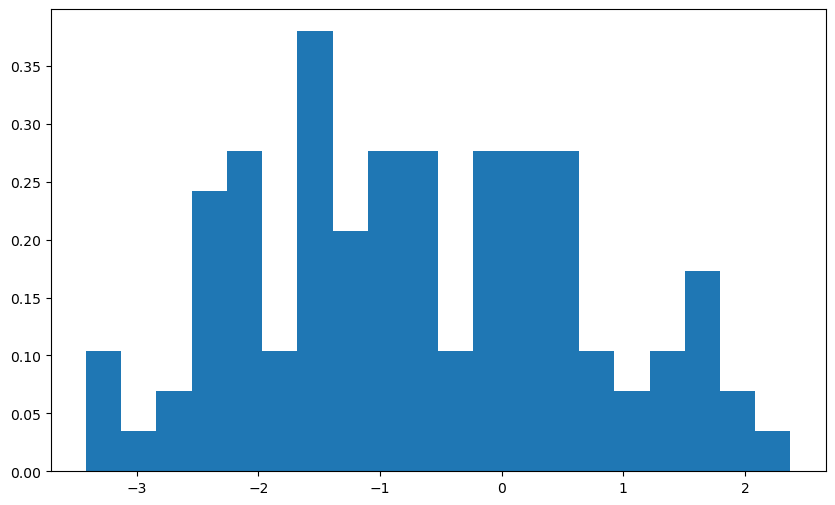

In [10]:
prior = stats.uniform()
theta0 = prior.rvs()

ber = stats.bernoulli(theta0)
normp = stats.norm(loc=1)
normm = stats.norm(loc=-1)

n = 100
choice = ber.rvs(size=n)
X = choice * normp.rvs(size=n) + (1-choice) * normm.rvs(size=n)

plt.figure(figsize = (10,6))
print(f'theta0 = {theta0}')
plt.hist(X, bins = 20, density = True);

>**Question 2.**
Expliciter la loi a posteriori $\Pi[\cdot | \mathbf X]$ et l'estimateur de Bayes $\hat \theta_n$ pour la perte quadratique.

La densité a posteriori s'obtient par la formule de Bayes :
$$\pi(\theta|{\bf X})=\frac{\pi(\theta) p_\theta (\bf X)}{f({\bf X})}=C_{\bf X}\prod_{i=1}^n\left\{\theta\phi(X_i-1)+(1-\theta)\phi(X_i+1)\right\}\mathbf{1}_{[0,1]}(\theta),$$
où, comme d'habitude, la constante de normalisation
$$C_{\bf X}=\left(\displaystyle\int_0^1\prod_{i=1}^n\left\{t\phi(X_i-1)+(1-t)\phi(X_i+1)\right\}dt\right)^{-1}$$
dépend de ${\bf X}$ mais pas de $\theta$. L'estimateur de Bayes pour la perte quadratique $\hat\theta_n$ est par définition l'espérance de $\boldsymbol \theta | \mathbf X$, c'est-à-dire
$$\hat\theta_n=\displaystyle\int_\mathbb{R}\theta\ \pi(\theta|{\bf X}) d\theta=C_{{\bf X}}\displaystyle\int_0^1\theta\prod_{i=1}^n\left\{\theta\phi(X_i-1)+(1-\theta)\phi(X_i+1)\right\}d\theta.$$
On ne dispose pas de formule analytique évidente pour calculer cette intégrale, d'où le recours aux méthodes Monte-Carlo dans la suite.

>**Question 3.**
En déduire un estimateur Monte-Carlo $\hat\theta_n^N$ de la réalisation de l'estimateur de Bayes $\hat\theta_n$. L'implémenter pour $N=500$ par exemple. 

On sait que $\hat \theta_n = \mathbb{E}[\boldsymbol \theta | \boldsymbol X] = \displaystyle \int_\mathbb{R} \dfrac{\theta p_\theta(\boldsymbol X) \pi(\theta) \, d\theta}{\displaystyle \int_\mathbb{R} p_t(\boldsymbol X) \pi(t) \, dt} = \dfrac{\displaystyle \int_\mathbb{R} \theta p_\theta(\boldsymbol X) \pi(\theta) \, d\theta}{\displaystyle \int_\mathbb{R} p_t(\boldsymbol X) \pi(t) \, dt}.$ 

Ainsi un estimateur Monte-Carlo $\hat\theta_n^N$ de la réalisation de l'estimateur de Bayes $\hat\theta_n$ est 
$$\hat\theta_n^N=\frac{\tfrac{1}{N}\sum_{j=1}^N \theta_j p_{\theta_j}(\mathbf X)}{\tfrac{1}{N}\sum_{j=1}^N p_{\theta_j}(\mathbf X)}=\frac{\displaystyle\sum_{j=1}^N \theta_j\prod_{i=1}^n\left\{\theta_j\phi(X_i-1)+(1-\theta_j)\phi(X_i+1)\right\}}{\displaystyle\sum_{j=1}^N \prod_{i=1}^n\left\{\theta_j\phi(X_i-1)+(1-\theta_j)\phi(X_i+1)\right\}}.$$

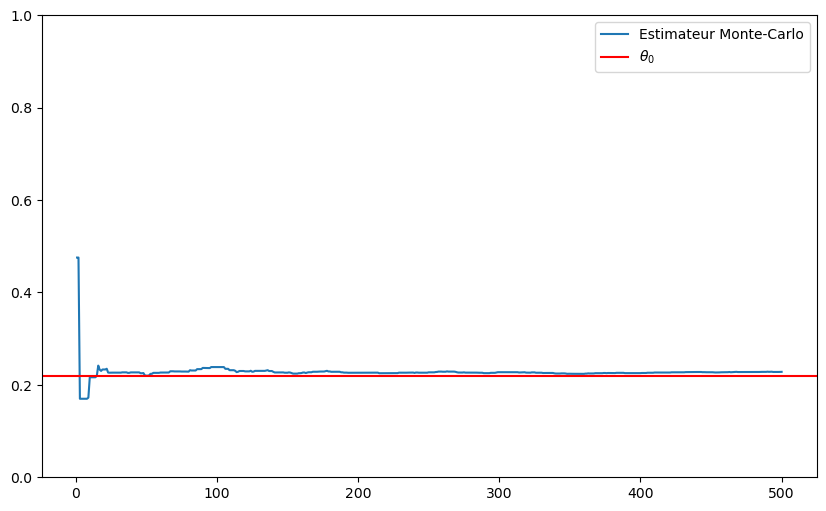

In [13]:
N = 500

thetas = prior.rvs(size = N)
likelihood = np.asarray([(theta * normp.pdf(X) + (1-theta) * normm.pdf(X)).prod() for theta in thetas])
estMC = (thetas * likelihood).cumsum() / likelihood.cumsum()

plt.figure(figsize = (10,6))
plt.plot(np.arange(1, N+1), estMC, label = "Estimateur Monte-Carlo")
plt.axhline(theta0, color="red", label="$\\theta_0$")
plt.ylim(0, 1)
plt.legend();

>**Question 4.**
>On souhaite générer un échantillon suivant la loi a posteriori $\Pi[\cdot | \mathbf X]$. On adopte pour cela la méthode de Metropolis-Hastings (qui fournira donc approximativement un échantillon de loi $\Pi[\cdot | \mathbf X]$, i.e. une trajectoire de loi cible $\Pi[\cdot | \mathbf X]$) avec comme noyau de proposition $q$, de sorte que $q(\theta,\theta')=\mathbf 1_{[0,1]}(\theta')$.
Quelle est la loi de proposition ?
Que vaut le rapport de Metropolis-Hastings $r(\theta,\theta')$ ?
>Avec la condition initiale $\boldsymbol \theta_1=1/2$, implémenter l'algorithme pour une chaîne de longueur $m=10^4$ et représenter un estimateur de la densité de la trajectoire $(\boldsymbol \theta_1,\dots,\boldsymbol \theta_m)$. Donner le taux global d'acceptation sur l'ensemble des mutations proposées.


Clairement, la loi de proposition correspondante à $q$, dont la densité est, pour tout $\theta \in \mathbb R$, $q(\theta, \cdot)$, est la loi $\mathcal U([0, 1])$.
Elle est indépendante de $\theta$ (en particulier, ce n'est pas une loi translatée comme dans les cas précédents),
mais ce n'est qu'une proposition : le prochain point de la chaîne de Markov dépendra, lui, bien du point courant (cf le rapport de Metropolis-Hastings).

Par ailleurs, le rapport de Metropolis-Hastings vaut, pour tous $\theta \in \mathbb R$ et $\theta' \in \mathbb R$ :
\begin{align*}
  r(\theta,\theta')
  &= \frac{\pi(\theta' | {\mathbf X})}{\pi(\theta | {\mathbf X})} \frac{q(\theta', \theta)}{q(\theta, \theta')}
  = \frac{\pi(\theta') p_{\theta'}(\mathbf X)}{\pi(\theta) p_{\theta}(\mathbf X)} \frac{q(\theta', \theta)}{q(\theta, \theta')}
  = \frac{\mathbf 1_{[0, 1]}(\theta') p_{\theta'}(\mathbf X)}{\mathbf 1_{[0, 1]}(\theta) p_{\theta}(\mathbf X)} \frac{\mathbf 1_{[0, 1]}(\theta)}{\mathbf 1_{[0, 1]}(\theta')} \\
  &= \frac{p_{\theta'}(\mathbf X)}{p_{\theta}(\mathbf X)}
  = \frac{\prod_{i=1}^n\left\{\theta'\phi(X_i-1)+(1-\theta')\phi(X_i+1)\right\}}{\prod_{i=1}^n\left\{\theta\phi(X_i-1)+(1-\theta)\phi(X_i+1)\right\}}.
\end{align*}

Taux d'acceptation : 0.18


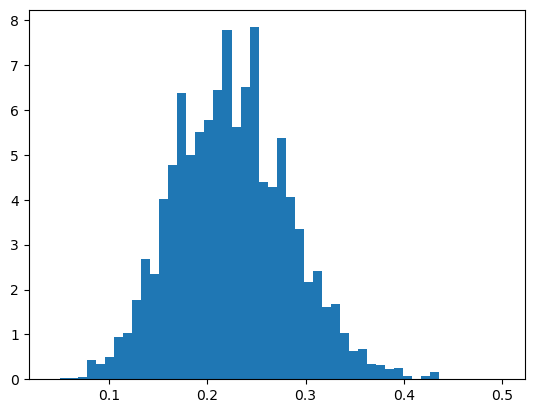

In [14]:
m = 10**4
init = 0.5

threshold = prior.rvs(size=m-1)
move = prior.rvs(size=m-1)

sample = [init]
for i in range(m-1):
    x = sample[-1]
    y = move[i]
    crit = np.prod(y * normp.pdf(X) + (1-y) * normm.pdf(X)) / np.prod(x * normp.pdf(X) + (1-x) * normm.pdf(X))
    dec = threshold[i] < crit
    sample.append(y if dec else x)

plt.hist(sample, bins = 50, density = True)
print(f"Taux d'acceptation : {len(np.unique(sample)) / m:.2f}")

Il y a un faible taux d'acceptation avec cette méthode. 

>**Question 5.**
Mêmes questions en considérant le noyau de transition correspondant à $\boldsymbol \theta' = \boldsymbol \theta+\dfrac{U}{\sqrt{n}}$ (modulo 1), avec $U \sim \mathcal U_{[-1,1]}$.

Taux d'acceptation : 0.68


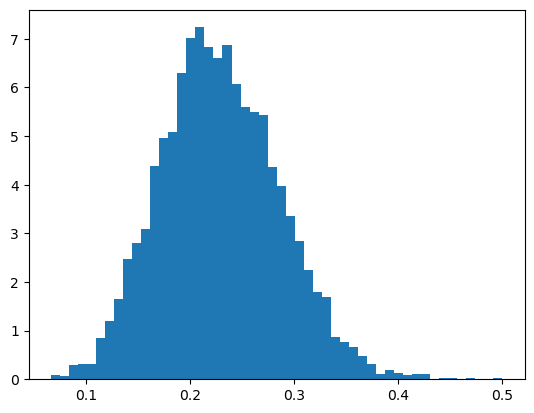

In [15]:
m = 10**4
init = 0.5

unif = stats.uniform()
kernel = stats.uniform(loc=-1, scale=2)

threshold = unif.rvs(size=m-1)
move = kernel.rvs(size=m-1) / np.sqrt(n)

sample = [init]
for i in range(m-1):
    x = sample[-1]
    y = (x + move[i]) % 1
    crit = np.prod(y * normp.pdf(X) + (1-y) * normm.pdf(X)) / np.prod(x * normp.pdf(X) + (1-x) * normm.pdf(X))
    dec = threshold[i] < crit
    sample.append(y if dec else x)

plt.hist(sample, bins = 50, density = True)
print(f"Taux d'acceptation : {len(np.unique(sample)) / m:.2f}")

## Exercice 6 : Slice sampler <a id="part6"></a>

On considère la fonction $f : (u,x) \in \mathbb R^2 \mapsto \mathbb 1_{0<u<\frac{1}{2}\exp \left(-\sqrt{x} \right)}$.

>**Question 1.**
Montrer que $g : x \mapsto \frac{1}{2}\exp \left(-\sqrt{x} \right)\mathbf 1_{x>0}$ est une densité sur $\mathbb{R}$. En déduire que $f$ est une densité sur $\mathbb{R}^2$.

$g(x) \geq 0$ pour tout $x \in \mathbb{R}$. Maintenant, $\displaystyle \int_\mathbb{R} g(x) \, dx  = \displaystyle \int_0^{+ \infty} \dfrac{1}{2} e^{-\sqrt{x}} \, dx = \displaystyle \int_0^{+ \infty} ue^{-u} \,du$, en faisant le changement de variables $u = \sqrt{x}$. Cette intégrale est égale à $1$, en reconnaissant $\mathbb{E}[\mathcal{E}(1)]$ ou encore on le montrant avec l'intégration par parties. Ainsi $g$ est une densité de probabilité sur $\mathbb{R}$. 

D'autre part, $f(u,x) \geq 0$ pour tout $(u,x) \in \mathbb{R}^2$. 
Par Fubini-Tonelli (tout étant positif) il vient que : $$\displaystyle \iint_{\mathbb{R}^2} f(u,x) \, dudx = \displaystyle \int_0^{+\infty} \displaystyle \int_0^{g(x)} dudx = \displaystyle \int_0^{+ \infty} g(x) \, dx = 1.$$
Finalement $f$ est une densité de probabilité sur $\mathbb{R}^2$. 

>**Question 2.**
Soit $(U, X)$ de densité $f$.
Déterminer, pour tout $(u, x) \in \mathbb R_+^2$, les lois conditionnelles de $U | X=x$ et $X | U=u$.

- $f_X(x) = \displaystyle \int_\mathbb{R} \mathbb 1_{0<u<\frac{1}{2}\exp \left(-\sqrt{x} \right)}\, du = \displaystyle \int_0^{\frac{1}{2}e^{-\sqrt{x}}} du \mathbb 1_{x > 0} = g(x)$. 

En notant que : $ 0 < u < \dfrac{1}{2}e^{-\sqrt{x}} \Leftrightarrow 0 < x < \ln(2u)^2,$

- $f_U(u) = \displaystyle \int_0^{\ln(2u)^2} \,dx \mathbb 1_{u > 0} = \ln(2u)^2 \mathbb 1_{u > 0}$.
- $f_{U| X = x}(u) = \dfrac{f(u,x)}{f_X(x)} = 2e^{\sqrt{x}}\mathbb 1_{0<u<\frac{1}{2}\exp \left(-\sqrt{x} \right)}$, donc $\mathcal L(U | X = x) = \mathcal{U}([0, \frac{1}{2}e^{-\sqrt{x}}])$.
- $f_{X | U = u}(x) = \dfrac{f(u,x)}{F_U(u)} = \dfrac{1}{\ln(2u)^2}\mathbb 1_{0 < x < \ln(2u)^2}$, donc $\mathcal L(X | U = u) = \mathcal{U}([0, \ln(2u)^2])$. 

>**Question 3.**
En partant du point $(U_1,X_1)=(1/(4e),1)$, implémenter un échantillonneur de Gibbs pour obtenir une trajectoire $(U_1,X_1),\dots,(U_n,X_n)$ de taille $n=1000$ et de densité cible $f$.

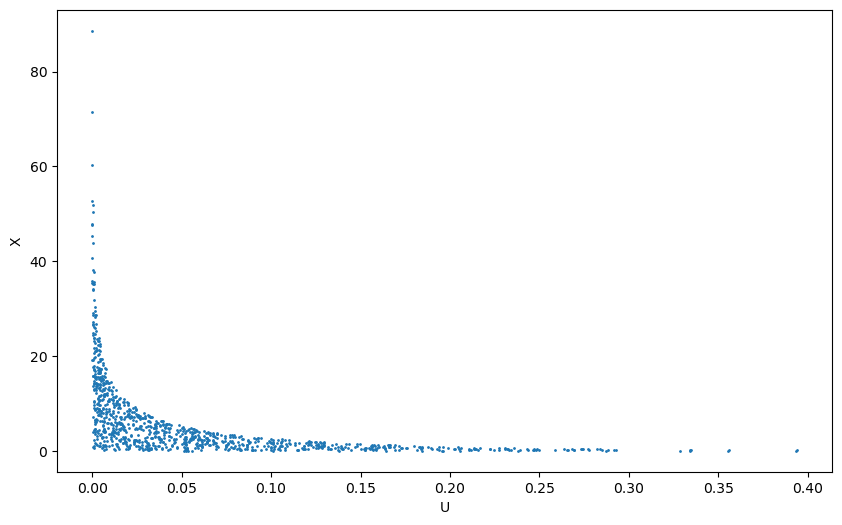

In [18]:
n = 1000
unif = stats.uniform()

U, X = [0.25/np.exp(1)], [1]

for i in range(n-1) : 
    U.append(unif.rvs() * np.exp(-np.sqrt(X[-1]))/2)
    X.append(unif.rvs() * np.log(2*U[-1])**2)
    
plt.figure(figsize = (10,6))
plt.scatter(U, X, 1)
plt.xlabel("U")
plt.ylabel("X")
plt.show()

>**Question 4.**
Sur un même graphe, représenter la densité $g(x)$ et un estimateur de la densité obtenu à partir de l'échantillon $X_1,\dots,X_n$.

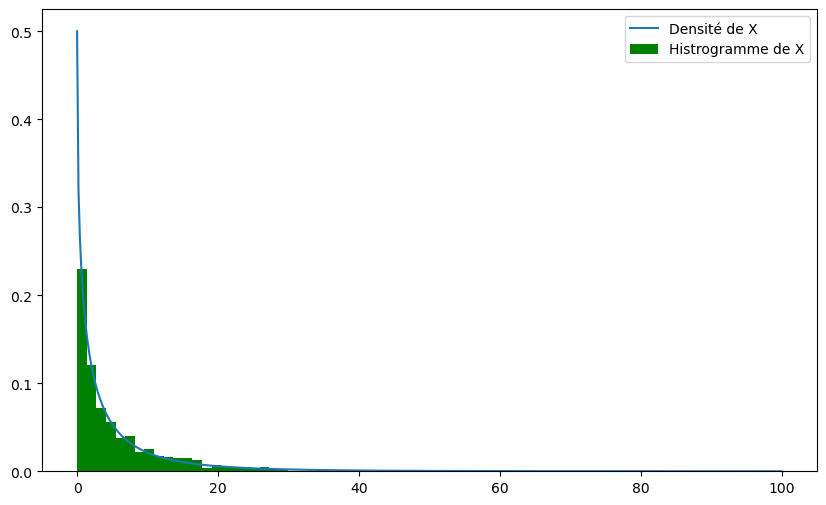

In [23]:
x = np.linspace(0, 100, 500)

plt.figure(figsize = (10, 6))
plt.plot(x, np.exp(-np.sqrt(x))/2, label = "Densité de X")
plt.hist(X, bins = 'auto', density = True, color = 'g', label="Histrogramme de X")
plt.legend();